In [1]:
import nltk
import eda_utils as eda_utils
import pandas as pd

dream = nltk.corpus.shakespeare.xml("dream.xml")
hamlet = nltk.corpus.shakespeare.xml("hamlet.xml")
macbeth = nltk.corpus.shakespeare.xml("macbeth.xml")
randj = nltk.corpus.shakespeare.xml("r_and_j.xml") 

andc = nltk.corpus.shakespeare.xml("a_and_c.xml") 
jcaesar = nltk.corpus.shakespeare.xml("j_caesar.xml") 
merchant = nltk.corpus.shakespeare.xml("merchant.xml") 
othello = nltk.corpus.shakespeare.xml("othello.xml") 

works = [ 
    {"work_xml": dream}, 
    {"work_xml": hamlet}, 
    {"work_xml": macbeth}, 
    {"work_xml": randj},
    {"work_xml": andc},
    {"work_xml": jcaesar},
    {"work_xml": merchant},
    {"work_xml": othello}
    ]

for w in works:
    eda_utils.extract_title_xml(w)
    main, side = eda_utils.extract_charcs_xml(w["work_xml"], print_charcs=False )
    w["main_charcs"] = main
    w["side_charcs"] = side

    w["parsed_play"] = eda_utils.parse_play_xml(w["work_xml"])

    w["merged"] = eda_utils.merge_play_data(w["parsed_play"], w["main_charcs"], w["side_charcs"])


all_data = []
for w in works:
    xml_tree = w["work_xml"]
    main, side = eda_utils.extract_charcs_xml(xml_tree, print_charcs=False)
    parsed = eda_utils.parse_play_xml(xml_tree)
    merged = eda_utils.merge_play_data(parsed, main, side)
    stats = eda_utils.summarize_play_stats(merged, main, side)
    df = stats["character_df"]  # extract the actual DataFrame
    all_data.append(df)


# --- Combine and export ---
combined_df = pd.concat(all_data, ignore_index=True)
combined_df.to_csv("../csv/all_plays_char_stats.csv", index=False)






A Midsummer Night's Dream
Acts: 5 | Scenes: 9 | Total Speeches: 500 | Total Lines: 2159
Main: 21 | Side: 2 | Ratio: 21:2

Act-level speech totals:
  Act 1: 90 speeches
  Act 2: 62 speeches
  Act 3: 180 speeches
  Act 4: 64 speeches
  Act 5: 104 speeches

Top 10 characters by line count:
                     play character  total_speeches  total_lines  scenes_appeared  acts_appeared  speech_share_pct  line_share_pct  avg_speeches_per_scene  avg_lines_per_speech  verbosity  talkativeness  dominance  focus  breadth  play_total_acts  play_total_scenes  play_total_speeches  play_total_lines main_side_ratio role_type
A Midsummer Night's Dream   THESEUS              48          233                3              3               9.6           10.79                   16.00                  4.85       4.85          16.00      10.79  77.67     0.33                5                  9                  500              2159            21:2      main
A Midsummer Night's Dream    HELENA              

In [2]:
def print_header(header_title: str):
    print("="*50)
    print(f"{header_title}")
    print("="*50)

In [3]:
import eda_utils as eda_utils

print_header("Character Networks")
eda_utils.build_networks_for_all(works)
print_header("Character Speeches")
eda_utils.extract_all_speeches_and_lines(works)
print_header("Story Stats")
eda_utils.create_story_stats(works)


Character Networks
Saved cleaned network for A Midsummer Night's Dream: ../csv/a_midsummer_night's_dream_network.csv
Saved cleaned network for The Tragedy of Hamlet, Prince of Denmark: ../csv/the_tragedy_of_hamlet,_prince_of_denmark_network.csv
Saved cleaned network for The Tragedy of Macbeth: ../csv/the_tragedy_of_macbeth_network.csv
Saved cleaned network for The Tragedy of Romeo and Juliet: ../csv/the_tragedy_of_romeo_and_juliet_network.csv
Saved cleaned network for The Tragedy of Antony and Cleopatra: ../csv/the_tragedy_of_antony_and_cleopatra_network.csv
Saved cleaned network for The Tragedy of Julius Caesar: ../csv/the_tragedy_of_julius_caesar_network.csv
Saved cleaned network for The Merchant of Venice: ../csv/the_merchant_of_venice_network.csv
Saved cleaned network for The Tragedy of Othello, the Moor of Venice: ../csv/the_tragedy_of_othello,_the_moor_of_venice_network.csv
Character Speeches
Extracting speeches and lines for A Midsummer Night's Dream...
Saved ../csv/a_midsummer_

,Play,Acts,Scenes,Speeches,Dialogue Lines,Main Characters,Side Characters,Total Characters,Avg Lines/Scene,Avg Speeches/Scene,Avg Lines/Speech
0,A Midsummer Night's Dream,5,9,498,2149,21,2,23,238.78,55.33,4.32
1,"The Tragedy of Hamlet, Prince of Denmark",5,20,1116,3978,21,5,26,198.90,55.80,3.56
2,The Tragedy of Macbeth,5,28,647,2373,21,5,26,84.75,23.11,3.67
3,The Tragedy of Romeo and Juliet,5,24,836,3080,18,7,25,128.33,34.83,3.68
4,The Tragedy of Antony and Cleopatra,5,42,1167,3533,33,1,34,84.12,27.79,3.03
5,The Tragedy of Julius Caesar,5,18,789,2587,33,2,35,143.72,43.83,3.28
6,The Merchant of Venice,5,20,636,2655,17,5,22,132.75,31.80,4.17
7,"The Tragedy of Othello, the Moor of Venice",5,15,1171,3533,11,3,14,235.53,78.07,3.02


In [4]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_play_network_centrality(
    play_name: str,
    csv_dir: str = "../csv",
    out_dir: str = "../figures",
    label_top_n: int = 12,
    layout: str = "spring",
    seed: int = 42,
    max_nodes: int = 30  # New parameter to filter network size
):
    """
    Enhanced network visualization with betweenness centrality.
    - Node size & color ~ betweenness centrality
    - Edge width ~ scenes shared
    - Labels: top-N by centrality
    - Improved colors, spacing, and visual hierarchy
    - Reduced node overlap through filtering and better layouts
    """
    os.makedirs(out_dir, exist_ok=True)
    net_path = os.path.join(csv_dir, f"{play_name}_network.csv")
    
    if not os.path.exists(net_path):
        print(f"Missing file: {net_path}")
        return
    
    df = pd.read_csv(net_path)
    
    # --- Build graph ---
    G = nx.Graph()
    for _, row in df.iterrows():
        a, b, w = str(row["Character A"]).strip(), str(row["Character B"]).strip(), int(row["Scenes Together"])
        if a and b and a != b:
            G.add_edge(a, b, weight=w)
    
    if G.number_of_nodes() == 0:
        print(f"No nodes for {play_name}. Skipping.")
        return
    
    # --- Calculate centrality on full graph ---
    centrality = nx.betweenness_centrality(G, normalized=True, endpoints=True)
    
    # --- Filter to top N characters by centrality to reduce overlap ---
    if G.number_of_nodes() > max_nodes:
        top_chars = sorted(centrality, key=centrality.get, reverse=True)[:max_nodes]
        G = G.subgraph(top_chars).copy()
        print(f"Filtered to top {max_nodes} characters by centrality")
    
    # --- Layout with better spacing ---
    if layout == "kamada":
        pos = nx.kamada_kawai_layout(G)
    elif layout == "spectral":
        pos = nx.spectral_layout(G)
    else:  # spring
        # Increased k for more spacing, more iterations for better convergence
        pos = nx.spring_layout(G, k=4.0, iterations=1000, seed=seed)
    
    # --- Metrics (recalculate for filtered graph) ---
    centrality_filtered = {n: centrality[n] for n in G.nodes()}
    
    # Enhanced node size calculation with reduced maximum size
    max_cent = max(centrality_filtered.values())
    min_cent = min(centrality_filtered.values())
    cent_range = max_cent - min_cent if max_cent > min_cent else 1
    
    # Reduced size range to minimize overlap (was 500-5500, now 300-3300)
    node_sizes = [300 + 3000 * ((centrality_filtered[n] - min_cent) / cent_range) ** 0.7 for n in G.nodes()]
    node_colors = [centrality_filtered[n] for n in G.nodes()]
    
    # Enhanced edge width calculation
    edge_weights = [d["weight"] for _, _, d in G.edges(data=True)]
    max_weight = max(edge_weights)
    min_weight = min(edge_weights)
    weight_range = max_weight - min_weight if max_weight > min_weight else 1
    edge_widths = [0.3 + 2.5 * ((w - min_weight) / weight_range) for w in edge_weights]
    
    # --- Plot with improved styling ---
    fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')
    ax.set_facecolor('#fafafa')
    
    # Title with better formatting
    title = play_name.replace("_", " ").title()
    ax.set_title(title, fontsize=20, pad=20, fontweight='bold', family='serif')
    
    # Draw edges with gradient transparency based on weight
    edge_alphas = [0.1 + 0.4 * ((w - min_weight) / weight_range) for w in edge_weights]
    for (u, v, d), width, alpha in zip(G.edges(data=True), edge_widths, edge_alphas):
        nx.draw_networkx_edges(
            G, pos, 
            edgelist=[(u, v)],
            width=width, 
            alpha=alpha, 
            edge_color='#404040',
            ax=ax
        )
    
    # Draw nodes with improved colormap and styling
    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.viridis,  # Better colormap than 'cool'
        edgecolors='white',
        linewidths=2.5,
        alpha=0.95,
        ax=ax
    )
    
    # --- Enhanced labels for top-N by centrality ---
    top_nodes = sorted(centrality_filtered, key=centrality_filtered.get, reverse=True)[:label_top_n]
    
    # Create labels dictionary
    labels = {n: n for n in top_nodes}
    
    # Draw labels with improved styling
    for node, (x, y) in pos.items():
        if node in labels:
            # Determine font size based on centrality
            font_size = 9 + 4 * (centrality_filtered[node] / max_cent)
            font_weight = 'bold' if centrality_filtered[node] > max_cent * 0.5 else 'semibold'
            
            ax.text(
                x, y, node,
                fontsize=font_size,
                fontweight=font_weight,
                ha='center',
                va='center',
                bbox=dict(
                    facecolor='white',
                    edgecolor='none',
                    alpha=0.85,
                    boxstyle='round,pad=0.4'
                ),
                zorder=1000
            )
    
    # --- Enhanced Colorbar ---
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.viridis,
        norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors))
    )
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6, aspect=20, pad=0.02)
    cbar.set_label("Betweenness Centrality", fontsize=12, fontweight='semibold')
    cbar.ax.tick_params(labelsize=10)
    
    # Add subtle grid for reference
    ax.grid(True, alpha=0.1, linestyle='--', linewidth=0.5)
    ax.axis("off")
    
    fig.tight_layout()
    
    out_path = os.path.join(out_dir, f"{play_name}_network_centrality.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight", facecolor='white')
    plt.close()
    
    print(f"Saved: {out_path}")
    
    # Print top characters for reference
    print(f"\nTop {label_top_n} characters by betweenness centrality:")
    for i, node in enumerate(top_nodes, 1):
        print(f"  {i}. {node}: {centrality_filtered[node]:.4f}")


# Example usage
if __name__ == "__main__":
    works = [
        "the_tragedy_of_romeo_and_juliet",
        "the_tragedy_of_macbeth",
        "the_tragedy_of_hamlet,_prince_of_denmark",
        "a_midsummer_night's_dream",
        "the_tragedy_of_othello,_the_moor_of_venice",
        "the_tragedy_of_julius_caesar",
        "the_tragedy_of_antony_and_cleopatra",
        "the_merchant_of_venice"
    ]

    for w in works:
        plot_play_network_centrality(
            play_name=w,
            csv_dir="../csv",
            out_dir="./figures",
            label_top_n=15,
            layout="spring",  
            seed=42,
            max_nodes=15  # Filter to top n characters
        )

Filtered to top 15 characters by centrality
Saved: ./figures/the_tragedy_of_romeo_and_juliet_network_centrality.png

Top 15 characters by betweenness centrality:
  1. CAPULET: 0.1674
  2. ROMEO: 0.1650
  3. LADY CAPULET: 0.1639
  4. FRIAR LAURENCE: 0.1416
  5. NURSE: 0.0919
  6. PARIS: 0.0914
  7. BENVOLIO: 0.0861
  8. PRINCE: 0.0857
  9. MONTAGUE: 0.0857
  10. JULIET: 0.0832
  11. TYBALT: 0.0782
  12. BALTHASAR: 0.0750
  13. PETER: 0.0682
  14. MERCUTIO: 0.0626
  15. FIRST CITIZEN: 0.0619
Filtered to top 15 characters by centrality
Saved: ./figures/the_tragedy_of_macbeth_network_centrality.png

Top 15 characters by betweenness centrality:
  1. MACBETH: 0.2859
  2. LENNOX: 0.1985
  3. ROSS: 0.1712
  4. LADY MACBETH: 0.1303
  5. BANQUO: 0.1275
  6. MACDUFF: 0.0980
  7. MALCOLM: 0.0936
  8. FIRST MURDERER: 0.0922
  9. ALL: 0.0781
  10. DOCTOR: 0.0663
  11. ANGUS: 0.0633
  12. MESSENGER: 0.0591
  13. SIWARD: 0.0586
  14. MENTEITH: 0.0579
  15. FIRST WITCH: 0.0534
Filtered to top 15 charac

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_all_scene_dominance(
    csv_dir: str = "../csv",
    out_dir: str = "./figures",
    top_n: int = 6,
    normalize: bool = False
):
    """
    Generates scene-level dominance plots for all <play>_speeches.csv files in csv_dir.
    Saves each figure to out_dir as a PNG.
    """
    os.makedirs(out_dir, exist_ok=True)
    speech_files = [f for f in os.listdir(csv_dir) if f.endswith("_speeches.csv")]

    for f in speech_files:
        path = os.path.join(csv_dir, f)
        df = pd.read_csv(path)

        if df.empty:
            continue

        # --- Aggregate total lines per scene/character
        scene_summary = (
            df.groupby(["Act", "Scene", "Character"], as_index=False)["Line Count"]
              .sum()
              .rename(columns={"Line Count": "Total Lines"})
        )

        # Pick top N talkers
        total_lines = (
            scene_summary.groupby("Character")["Total Lines"]
            .sum()
            .sort_values(ascending=False)
        )
        top_chars = total_lines.head(top_n).index

        plot_df = scene_summary[scene_summary["Character"].isin(top_chars)].copy()

        # Normalize if requested
        if normalize:
            scene_totals = plot_df.groupby(["Act", "Scene"])["Total Lines"].transform("sum")
            plot_df["Line Share (%)"] = plot_df["Total Lines"] / scene_totals * 100
            y_col = "Line Share (%)"
            y_label = "Share of Scene Dialogue (%)"
        else:
            y_col = "Total Lines"
            y_label = "Dialogue Lines"

        # Combine Act.Scene for x-axis
        plot_df["Scene ID"] = plot_df["Act"].astype(str) + "." + plot_df["Scene"].astype(str)

        # --- Plot ---
        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=plot_df,
            x="Scene ID", y=y_col,
            hue="Character",
            marker="o", linewidth=2, alpha=0.9
        )

        title = f.replace("_speeches.csv", "").replace("_", " ").title()
        plt.title(f"{title} — Character Dialogue Over Scenes", fontsize=14, pad=12)
        plt.xlabel("Scene (Act.Scene)")
        plt.ylabel(y_label)
        plt.xticks(rotation=45, ha="right")
        plt.grid(True, alpha=0.3)
        plt.legend(title="Character", bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()

        out_path = os.path.join(out_dir, f.replace("_speeches.csv", "_scene_dominance.png"))
        plt.savefig(out_path, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"Saved {out_path}")


plot_all_scene_dominance(csv_dir="../csv", out_dir="./figures", top_n=4, normalize=False)


Saved ./figures/the_tragedy_of_antony_and_cleopatra_scene_dominance.png
Saved ./figures/the_merchant_of_venice_scene_dominance.png
Saved ./figures/the_tragedy_of_othello,_the_moor_of_venice_scene_dominance.png
Saved ./figures/the_tragedy_of_hamlet,_prince_of_denmark_scene_dominance.png
Saved ./figures/a_midsummer_nights_dream_scene_dominance.png
Saved ./figures/the_tragedy_of_romeo_and_juliet_scene_dominance.png
Saved ./figures/the_tragedy_of_julius_caesar_scene_dominance.png
Saved ./figures/the_tragedy_of_macbeth_scene_dominance.png


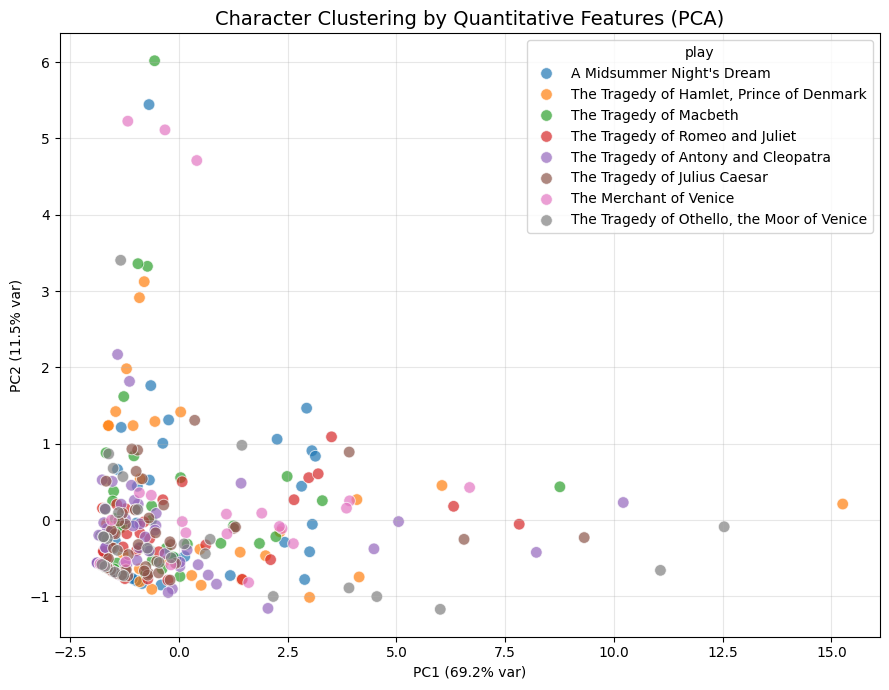

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def plot_character_clustering(csv_file="../csv/all_plays_character_stats.csv"):
    """
    Simple 2D clustering visualization using PCA on character quantitative features.
    """
    df = pd.read_csv(csv_file)

    # Choose relevant numeric features
    features = [
        "total_speeches", "total_lines", "scenes_appeared",
        "acts_appeared", "verbosity", "talkativeness",
        "dominance", "focus", "breadth"
    ]
    X = df[features].fillna(0)

    # Scale features
    X_scaled = StandardScaler().fit_transform(X)

    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    coords = pca.fit_transform(X_scaled)
    df["PC1"], df["PC2"] = coords[:, 0], coords[:, 1]

    # Plot
    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data=df, x="PC1", y="PC2", hue="play",
        alpha=0.7, s=70, palette="tab10"
    )
    plt.title("Character Clustering by Quantitative Features (PCA)", fontsize=14)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_character_clustering("../csv/all_plays_char_stats.csv")


/Users/jazzydelossantos/Desktop/CalPoly/fall-qtr-25/csc466_finalproj/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jazzydelossantos/Desktop/CalPoly/fall-qtr-25/csc466_finalproj/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


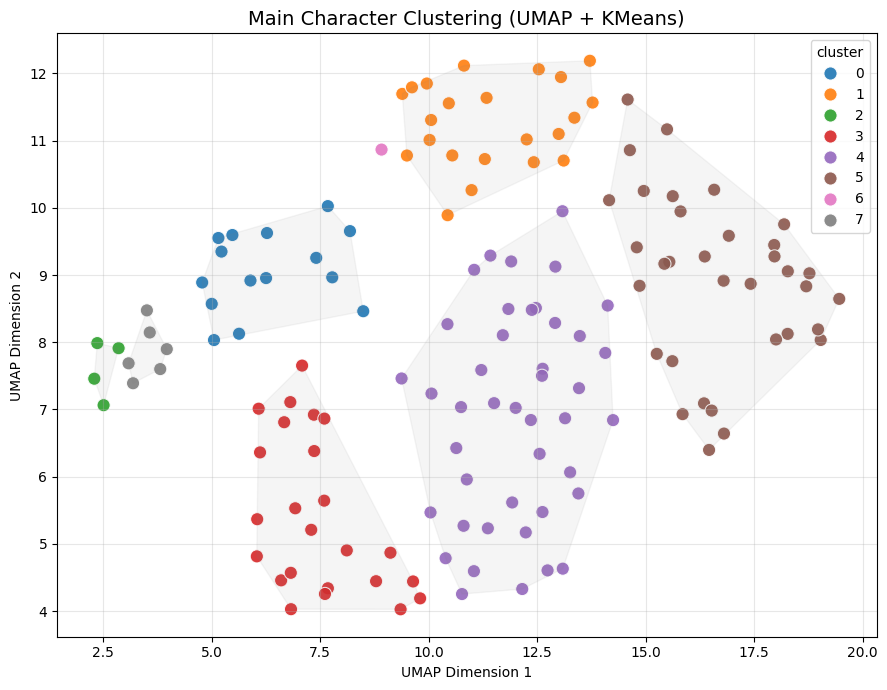


Cluster summary (top 5 main characters per cluster)


  Cluster 0: 
OCTAVIUS CAESAR (The Tragedy of Antony and Cleopatra),
DOMITIUS ENOBARBUS (The Tragedy of Antony and Cleopatra),
SHYLOCK (The Merchant of Venice),
FRIAR LAURENCE (The Tragedy of Romeo and Juliet),
BASSANIO (The Merchant of Venice)

  Cluster 1: 
EGEUS (A Midsummer Night's Dream),
MONTAGUE (The Tragedy of Romeo and Juliet),
MARULLUS (The Tragedy of Julius Caesar),
VENTIDIUS (The Tragedy of Antony and Cleopatra),
CALPURNIA (The Tragedy of Julius Caesar)

  Cluster 2: 
HAMLET (The Tragedy of Hamlet, Prince of Denmark),
IAGO (The Tragedy of Othello, the Moor of Venice),
OTHELLO (The Tragedy of Othello, the Moor of Venice),
MARK ANTONY (The Tragedy of Antony and Cleopatra)

  Cluster 3: 
DESDEMONA (The Tragedy of Othello, the Moor of Venice),
HORATIO (The Tragedy of Hamlet, Prince of Denmark),
CASSIO (The Tragedy of Othello, the Moor of Venice),
EMILIA (The Tragedy of Othello, the Moor of Venice),
LAERTES (The Tragedy of H

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap.umap_ as umap
from scipy.spatial import ConvexHull

def cluster_main_characters_umap_kmeans(
    csv_file="../csv/all_plays_char_stats.csv",
    n_clusters=8,
    n_neighbors=8,
    min_dist=0.3,
    label_top_n=10,
    random_state=42,
    draw_hulls=True
):
    """
    Cluster MAIN characters using UMAP + KMeans.
    - Each point = main character
    - Color = cluster (potential archetype group)
    - Labels = top-N most talkative characters (with play names)
    - Optionally draws convex hulls for clarity
    """
    df = pd.read_csv(csv_file)

    # --- Filter main characters ---
    if "role_type" not in df.columns:
        raise ValueError("CSV must include a 'Role Type' column.")
    df_main = df[df["role_type"].str.lower() == "main"].copy()

    if df_main.empty:
        print("No main characters found.")
        return

    # --- Select reduced feature set (less correlated) ---
    features = ["total_lines", 
                "dominance", 
                "verbosity", 
                "breadth", 
                "focus"]
    X = df_main[features].fillna(0).copy()

    # --- Log-transform skewed features ---
    for col in ["total_lines", "dominance"]:
        X[col] = np.log1p(X[col])

    # --- Scale ---
    X_scaled = StandardScaler().fit_transform(X)

    # --- Dimensionality reduction (UMAP) ---
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state
    )
    coords = reducer.fit_transform(X_scaled)
    df_main["UMAP1"], df_main["UMAP2"] = coords[:, 0], coords[:, 1]

    # --- Clustering (KMeans) ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    df_main["cluster"] = kmeans.fit_predict(X_scaled)

    # --- Plot ---
    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data=df_main,
        x="UMAP1", y="UMAP2",
        hue="cluster", palette="tab10",
        s=90, alpha=0.9
    )

    plt.title("Main Character Clustering (UMAP + KMeans)", fontsize=14)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(alpha=0.3)

    # --- Optional: convex hulls for clarity ---
    if draw_hulls:
        for cluster in df_main["cluster"].unique():
            pts = df_main[df_main["cluster"] == cluster][["UMAP1", "UMAP2"]].values
            if len(pts) > 2:
                hull = ConvexHull(pts)
                plt.fill(
                    pts[hull.vertices, 0], pts[hull.vertices, 1],
                    alpha=0.08, color="gray"
                )

    # --- Label key characters (with play names) ---
    top_chars = df_main.nlargest(label_top_n, "total_lines")
    for _, row in top_chars.iterrows():
        label = f"{row['character']} ({row['play']})"
        plt.text(
            row["UMAP1"], row["UMAP2"], label,
            fontsize=8.5, weight="bold",
            ha="center", va="center",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round,pad=0.2")
        )

    plt.tight_layout()
    plt.show()

    # --- Print cluster summary with play names ---
    print("\nCluster summary (top 5 main characters per cluster)\n\n")
    for cluster in sorted(df_main["cluster"].unique()):
        chars = (
            df_main[df_main["cluster"] == cluster]
            .nlargest(5, "total_lines")[["character", "play"]]
            .apply(lambda r: f"{r['character']} ({r['play']})", axis=1)
            .tolist()
        )
        print(f"  Cluster {cluster}: \n{',\n'.join(chars)}")
        print()

    return df_main

# Run your existing function (as you did)
clustered_df = cluster_main_characters_umap_kmeans(
    csv_file="../csv/all_plays_char_stats.csv",
    n_clusters=8,
    n_neighbors=10,
    min_dist=0.8,
    label_top_n=0
)

# # --- Merge the new cluster info back into the full CSV ---
# # Load the original file
# df_all = pd.read_csv("../csv/all_plays_char_stats.csv")

# # Merge cluster assignments back (only for main characters)
# df_all = df_all.merge(
#     clustered_df[["character", "play", "cluster"]],
#     on=["character", "play"],
#     how="left"
# )

# # Save the updated version
# df_all.to_csv("../csv/all_plays_char_stats_with_clusters.csv", index=False)

# print("Saved updated CSV with Cluster column as '../csv/all_plays_char_stats_with_clusters.csv'")



In [8]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

df = pd.read_csv("../csv/the_tragedy_of_romeo_and_juliet_speeches.csv")

# Example: df has a column "lines" containing all of a character’s dialogue concatenated as a string
sia = SentimentIntensityAnalyzer()

# Apply sentiment analyzer
df['sentiment'] = df['Text'].apply(lambda text: sia.polarity_scores(str(text))['compound'])

# Optional: split into more detail
df['sent_pos'] = df['Text'].apply(lambda text: sia.polarity_scores(str(text))['pos'])
df['sent_neg'] = df['Text'].apply(lambda text: sia.polarity_scores(str(text))['neg'])
df['sent_neu'] = df['Text'].apply(lambda text: sia.polarity_scores(str(text))['neu'])

# df.groupby('Character')['sentiment'].mean()
df


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jazzydelossantos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Play,Act,Scene,Character,Line Count,Text,sentiment,sent_pos,sent_neg,sent_neu
0,The Tragedy of Romeo and Juliet,1,1,SAMPSON,8,"Gregory, o' my word, we'll not carry coals.",0.0000,0.000,0.000,1.000
1,The Tragedy of Romeo and Juliet,1,1,GREGORY,7,"No, for then we should be colliers.",-0.2960,0.000,0.268,0.732
2,The Tragedy of Romeo and Juliet,1,1,SAMPSON,9,"I mean, an we be in choler, we'll draw.",0.0000,0.000,0.000,1.000
3,The Tragedy of Romeo and Juliet,1,1,GREGORY,11,"Ay, while you live, draw your neck out o' the ...",0.0000,0.000,0.000,1.000
4,The Tragedy of Romeo and Juliet,1,1,SAMPSON,5,"I strike quickly, being moved.",-0.1280,0.000,0.333,0.667
...,...,...,...,...,...,...,...,...,...,...
829,The Tragedy of Romeo and Juliet,5,3,PRINCE,85,"This letter doth make good the friar's words, ...",-0.9018,0.157,0.254,0.589
830,The Tragedy of Romeo and Juliet,5,3,CAPULET,18,"O brother Montague, give me thy hand: This is ...",0.0571,0.159,0.197,0.644
831,The Tragedy of Romeo and Juliet,5,3,MONTAGUE,39,But I can give thee more: For I will raise her...,0.6956,0.170,0.063,0.767
832,The Tragedy of Romeo and Juliet,5,3,CAPULET,13,As rich shall Romeo's by his lady's lie; Poor ...,0.2003,0.216,0.172,0.611


In [9]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

df = pd.read_csv("../csv/the_tragedy_of_romeo_and_juliet_lines.csv")

# Example: df has a column "lines" containing all of a character’s dialogue concatenated as a string
sia = SentimentIntensityAnalyzer()

# Apply sentiment analyzer
df['sentiment'] = df['Text'].apply(lambda text: sia.polarity_scores(str(text))['compound'])

# Optional: split into more detail
df['sent_pos'] = df['Text'].apply(lambda text: sia.polarity_scores(str(text))['pos'])
df['sent_neg'] = df['Text'].apply(lambda text: sia.polarity_scores(str(text))['neg'])
df['sent_neu'] = df['Text'].apply(lambda text: sia.polarity_scores(str(text))['neu'])

df.groupby('Character')['sentiment'].mean()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jazzydelossantos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Character
ABRAHAM           -0.036320
APOTHECARY        -0.054743
BALTHASAR         -0.037903
BENVOLIO          -0.003433
CAPULET            0.052224
FIRST CITIZEN     -0.169267
FIRST MUSICIAN     0.051333
FIRST SERVANT      0.173360
FIRST WATCHMAN    -0.175667
FRIAR JOHN        -0.094600
FRIAR LAURENCE     0.032218
GREGORY           -0.122975
JULIET             0.036678
LADY CAPULET       0.005649
LADY MONTAGUE      0.006133
MERCUTIO           0.047078
MONTAGUE           0.024456
MUSICIAN           0.458800
NURSE              0.050382
PAGE              -0.062812
PARIS             -0.073353
PETER              0.079461
PRINCE            -0.134539
ROMEO              0.050039
SAMPSON           -0.023417
SECOND CAPULET     0.000000
SECOND MUSICIAN   -0.025825
SECOND SERVANT     0.143000
SECOND WATCHMAN    0.000000
SERVANT            0.168657
THIRD MUSICIAN     0.421500
THIRD WATCHMAN    -0.120400
TYBALT            -0.172431
Name: sentiment, dtype: float64

In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

# Load line-level CSV
spoken_lines = pd.read_csv("../csv/the_tragedy_of_romeo_and_juliet_lines.csv")

# Combine all lines spoken by each character into a single document
char_texts = (
    spoken_lines.groupby("Character")["Text"]
    .apply(lambda lines: " ".join(lines))
    .reset_index()
)

custom_stop_words = "thou", "thy", "thee", "ll"
combined_stop_words = set(ENGLISH_STOP_WORDS).union(custom_stop_words)

# Initialize vectorizer
vect = TfidfVectorizer(
    lowercase=True,
    stop_words=list(combined_stop_words),  # optional
    ngram_range=(1, 2),    # unigrams + bigrams if you like
    max_df=0.9,
    min_df=2
)

# Fit-transform the combined character text
tfidf_matrix = vect.fit_transform(char_texts["Text"])

# Get feature names (words)
feature_names = vect.get_feature_names_out()

# Convert to a DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=char_texts["Character"],
    columns=feature_names
)

# Example: show top 10 words per character
def top_terms_for_character(character, n=10):
    row = tfidf_df.loc[character]
    top_terms = row.sort_values(ascending=False).head(n)
    return top_terms

# Example usage
print(top_terms_for_character("ROMEO"))
print(top_terms_for_character("JULIET"))
print(top_terms_for_character("TYBALT"))


love        0.437732
death       0.171210
beauty      0.142429
dear        0.138326
fair        0.137546
juliet      0.134687
night       0.126269
eyes        0.124854
farewell    0.117045
man         0.112467
Name: ROMEO, dtype: float64
romeo     0.297492
love      0.295615
night     0.253384
shall     0.203119
nurse     0.202474
come      0.174142
sweet     0.154182
st        0.132092
tybalt    0.118246
good      0.117808
Name: JULIET, dtype: float64
villain      0.279440
hate         0.234220
boy          0.221017
scorn        0.195725
consort      0.195725
solemnity    0.195725
drawn        0.195725
uncle        0.179299
shall        0.155739
romeo        0.150211
Name: TYBALT, dtype: float64
